## Irap & Mona data merge, EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression 

In [2]:
path = "../Final Soft Launch Results/Current Source Data/"

In [3]:
d1="Data from IRAP 01072020.xlsx"
# d2="Merge for Vulnerability Screening.xlsx"
d3="Raw Data from Mona 01172020.xlsx"

In [4]:
irap = pd.read_excel (path+d1)
# merge = pd.read_excel (path+d2)
mona = pd.read_excel (path+d3)

In [5]:
irap['process_days'] = irap['Date of Screening Decision']-irap['Date of Screening Start']
irap['process_days'] = irap['process_days'].astype('timedelta64[D]')

In [6]:
mona = mona.rename({'Contact UUID': 'Mona Unique User ID'}, axis=1)

#### Joining tables into "full"

In [7]:
full = pd.merge(irap, mona, on='Mona Unique User ID',how="left").dropna(axis=1, how='all')

In [8]:
full['Field:Gender'].replace(('Male', 'Female'), (1, 0), inplace=True)
full['Vulnerability Threshold'].replace(('Above', 'Below'), (1, 0), inplace=True)

#### Create one-hot features

In [9]:
def one_hot(dataframe,column_name):
    gen_onehot_features = pd.get_dummies(dataframe[column_name])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    return result

In [10]:
full['Field:Nationality1'] = 'nationality_' + full['Field:Nationality1']
full = one_hot(full,'Field:Nationality1')


In [11]:
full['Field:Current Country'] = 'curr_country_' + full['Field:Current Country']
full = one_hot(full,'Field:Current Country')

In [12]:
full.head()

,Mona Unique Session ID,Mona Unique User ID,Created on,Created by,Pipeline,Date of Referral,First Referral,In IRAP Process,Screening Stage,Screener,...,Field:Pause Handoffs,Field:Lebanon Location,nationality_Iraqi,nationality_Syrian,curr_country_Egypt,curr_country_Iraq,curr_country_Lebanon,curr_country_Saudi Arabia,curr_country_Syria,curr_country_Turkey
0,ce81140c-7083-4463-90ed-ad36d1a41011.2019-07-2...,ce81140c-7083-4463-90ed-ad36d1a41011,2019-12-11 06:02:17,Brooke Sauro,Mona,2019-07-25,No,No,Screening Complete,Michaela Gallien,...,NaN,NaN,0,1,0,0,1,0,0,0
1,92952aa434524f549543d3fcc79054fe20190804T02434...,92952aa4-3452-4f54-9543-d3fcc79054fe,2019-12-11 06:02:17,Brooke Sauro,Mona,2019-08-03,No,Yes,Screening Complete,Manal ElKhoury,...,Yes,NaN,0,1,0,0,1,0,0,0
2,8a4a87a6eeeb43019d820644a8a7534620190802T07350...,8a4a87a6-eeeb-4301-9d82-0644a8a75346,2019-12-11 06:02:17,Brooke Sauro,Mona,2019-08-02,No,No,Screening,Tiba Fatli,...,NaN,NaN,0,1,0,0,1,0,0,0
3,758240c9578a4e29b66bd1d95de9cdc620190802T21293...,758240c9-578a-4e29-b66b-d1d95de9cdc6,2019-12-11 06:02:17,Brooke Sauro,Mona,2019-08-02,No,No,Screening Complete,Tania El Khoury,...,NaN,NaN,0,1,0,0,1,0,0,0
4,55865e62-97b3-4656-b470-7eaaa6a517cf.2019-07-2...,55865e62-97b3-4656-b470-7eaaa6a517cf,2019-12-11 06:02:16,Brooke Sauro,Mona,2019-07-26,No,No,Screening Complete,Tania El Khoury,...,Yes,طرابلس مخيم البداوي.,0,1,0,0,1,0,0,0


In [13]:
numeric = full.select_dtypes(exclude=['object','datetime64[ns]'])

In [14]:
multiple_vars = numeric[numeric['Field:Age'].notna() 
        & numeric['Field:Gender'].notna()
        & numeric['Field:Medical Condition Score'].notna()
        & numeric['Vulnerability Threshold'].notna()
        & numeric['Field:LPPN Score'].notna()
        & numeric['process_days'].notna()
       ].dropna(axis=1)

### Part A: Mona’s Vulnerability Scores versus Decision-Making Time:


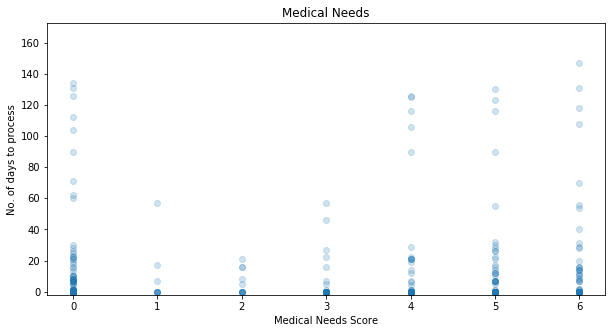

In [15]:
fig = plt.figure(figsize=[10,5])
plt.scatter(full['Field:Medical Needs Score'], full['process_days'], 
            marker="o",alpha=0.2)

plt.ylim(-2,)
plt.title("Medical Needs")
plt.xlabel("Medical Needs Score")
plt.ylabel("No. of days to process")

plt.show()

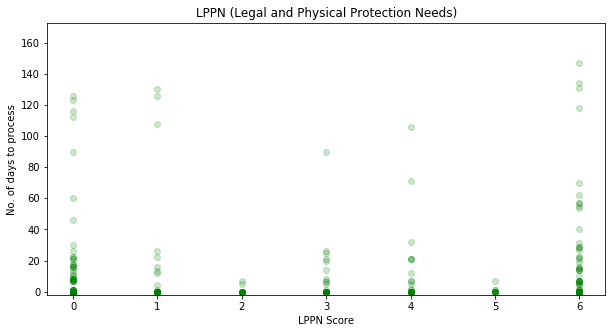

In [16]:
fig = plt.figure(figsize=[10,5])
plt.scatter(full['Field:LPPN Score'], full['process_days'], 
            marker="o",alpha=0.2,c="g")

plt.ylim(-2,)
plt.title("LPPN (Legal and Physical Protection Needs)")
plt.xlabel("LPPN Score")
plt.ylabel("No. of days to process")

plt.show()

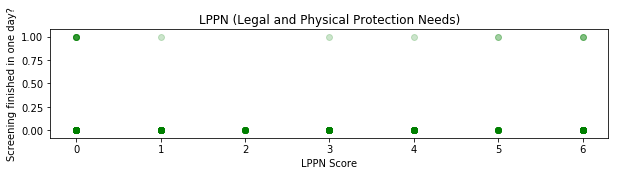

In [17]:
fig = plt.figure(figsize=[10,2])
plt.scatter(full['Field:LPPN Score'], [1 if i ==1 else 0 for i in full['process_days']], 
            marker="o",alpha=0.2,c="g")

# plt.ylim(-,)
plt.title("LPPN (Legal and Physical Protection Needs)")
plt.xlabel("LPPN Score")
plt.ylabel("Screening finished in one day?")

plt.show()

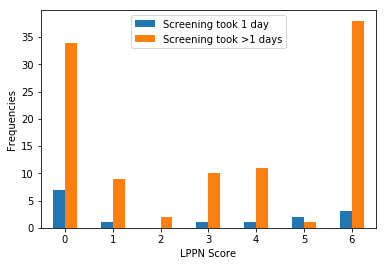

In [18]:
index = [0,1,2,3,4,5,6]
n_days = [full.loc[(full['Field:LPPN Score'] == i) & (full['process_days'] > 1)].shape[0] for i in index]
one_day = [full.loc[(full['Field:LPPN Score'] == i) & (full['process_days'] == 1)].shape[0] for i in index]
df = pd.DataFrame({'Screening took 1 day': one_day,
                   'Screening took >1 days': n_days}, index=index)
df.plot.bar(rot=0)
plt.xlabel("LPPN Score")
plt.ylabel("Frequencies")

plt.show()

### Part B: Mona’s Vulnerability Scores verses IRAP’s Above/Below Threshold


In [19]:
full['Vulnerability Threshold'].value_counts()

0.0    705
1.0     15
Name: Vulnerability Threshold, dtype: int64

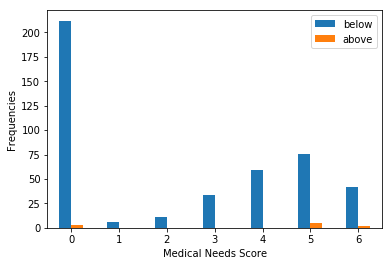

In [76]:
index = [0,1,2,3,4,5,6]
below = [full.loc[(full['Field:Medical Needs Score'] == i) & 
                    (full['Vulnerability Threshold'] ==0)].shape[0] for i in index]
above = [full.loc[(full['Field:Medical Needs Score'] == i) & 
                    (full['Vulnerability Threshold'] == 1)].shape[0] for i in index]
df = pd.DataFrame({'below': below,
                   'above': above}, index=index)
df.plot.bar(rot=0)
plt.xlabel("Medical Needs Score")
plt.ylabel("Frequencies")

plt.show()

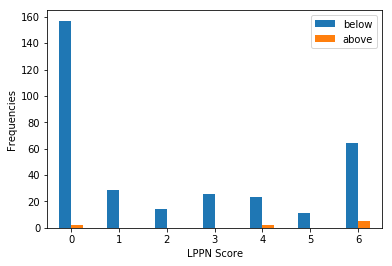

In [77]:
index = [0,1,2,3,4,5,6]

below = [full.loc[(full['Field:LPPN Score'] == i) & 
                    (full['Vulnerability Threshold'] == 0)].shape[0] for i in index]
above = [full.loc[(full['Field:LPPN Score'] == i) & 
                    (full['Vulnerability Threshold'] == 1)].shape[0] for i in index]
df = pd.DataFrame({'below': below,
                   'above': above}, index=index)
df.plot.bar(rot=0)
plt.xlabel("LPPN Score")
plt.ylabel("Frequencies")

plt.show()

### Cross tab distribution

In [22]:
pd.crosstab(full['Field:LPPN Score'],full['Vulnerability Threshold'],margins = False)

Vulnerability Threshold,0.0,1.0
Field:LPPN Score,,
0.0,157,2
1.0,29,0
2.0,14,0
3.0,26,0
4.0,23,2
5.0,11,0
6.0,64,5


In [23]:
157+29+14+26+23

249

In [27]:
full[full['Vulnerability Threshold']==1][['Vulnerability Threshold','Field:Medical Needs Score','Field:LPPN Score']]

,Vulnerability Threshold,Field:Medical Needs Score,Field:LPPN Score
275,1.0,0.0,4.0
358,1.0,5.0,6.0
361,1.0,6.0,6.0
406,1.0,5.0,NaN
459,1.0,0.0,6.0
468,1.0,NaN,NaN
520,1.0,5.0,0.0
623,1.0,6.0,6.0
686,1.0,5.0,6.0
716,1.0,5.0,0.0


In [28]:
pd.crosstab(full['Field:Medical Needs Score'],full['Vulnerability Threshold'],margins = False)

Vulnerability Threshold,0.0,1.0
Field:Medical Needs Score,,
0.0,212,3
1.0,6,0
2.0,11,0
3.0,34,0
4.0,59,0
5.0,76,5
6.0,42,2


In [29]:
212+6+11+34+59

322

In [30]:
pd.crosstab(full['Field:LPPN Score'],full['process_days']>1,margins = False)

process_days,False,True
Field:LPPN Score,,
0.0,177,34
1.0,36,9
2.0,19,2
3.0,34,10
4.0,30,11
5.0,19,1
6.0,106,38


In [31]:
34+9+2+10+11

66

In [32]:
pd.crosstab(full['Field:Medical Needs Score'],full['process_days']>1,margins = False)

process_days,False,True
Field:Medical Needs Score,,
0.0,265,44
1.0,8,3
2.0,9,5
3.0,41,7
4.0,71,17
5.0,120,27
6.0,58,28


In [33]:
44+3+5+7+17

76

### Pearsons correlations

In [34]:
medi_score = full[['Field:Medical Needs Score','process_days']].dropna()
pearsonr(medi_score['Field:Medical Needs Score'],medi_score['process_days'])

(0.08391809162662373, 0.06262573901534098)

In [35]:
def find_pearson_time(var):
    df = full[[var,'process_days']].dropna()
    p = pearsonr(df[var],df['process_days'])
#     print(var)
#     print("PEARSON: {:.5f} p-value: {:.5f}".format(p[0],p[1]))
    return(p[0])
    

In [36]:
def find_pearson_thresh(var):
    df = full[[var,'Vulnerability Threshold']].dropna()
    p = pearsonr(df[var],df['Vulnerability Threshold'])
#     print(var)
#     print("PEARSON: {:.5f} p-value: {:.5f}".format(p[0],p[1]))
    return(p[0])
    

In [37]:
find_pearson_time('Field:Medical Needs Score')

0.08391809162662373

In [38]:
full[' Mona Follow up Needed'].replace(('Yes', 'No'), (1, 0), inplace=True)
full['Mona Case Type Identification'].replace(('Accurate', 'Inaccurate'), (1, 0), inplace=True)
full['Screening Stage'].replace(('Screening Complete', 'Screening'), (1, 0), inplace=True)
full['In IRAP Process'].replace(('Yes', 'No'), (1, 0), inplace=True)
full['First Referral'].replace(('Yes', 'No'), (1, 0), inplace=True)
full["Flags"].fillna("responsive",inplace=True)
full['Flags'].replace(('Unresponsive', 'responsive'), (1, 0), inplace=True)

In [40]:
pearson_time = []
for i in [' Mona Follow up Needed', 'Mona Case Type Identification',
    'Screening Stage','In IRAP Process','First Referral','Flags',
         'Field:Medical Needs Score','Field:LPPN Score']:
    pearson_time.append((find_pearson_time(i),i))
sorted(pearson_time, key=lambda a: abs(a[0]), reverse=True)

[(0.4236875946096612, ' Mona Follow up Needed'),
 (0.2580631379674056, 'Flags'),
 (0.08391809162662373, 'Field:Medical Needs Score'),
 (0.06058520593503715, 'Field:LPPN Score'),
 (-0.046758139653815416, 'Mona Case Type Identification'),
 (0.04536128784220895, 'First Referral'),
 (0.020944797294969935, 'Screening Stage'),
 (-0.020920626497034474, 'In IRAP Process')]

In [41]:
pearson_thresh = []
for i in [' Mona Follow up Needed', 'Mona Case Type Identification',
    'Screening Stage','In IRAP Process','First Referral','Flags',
          'Field:Medical Needs Score','Field:LPPN Score']:
    pearson_thresh.append((find_pearson_thresh(i),i))
sorted(pearson_thresh, key=lambda a: abs(a[0]), reverse=True)

[(0.27644327266750335, ' Mona Follow up Needed'),
 (-0.15864057253285996, 'Screening Stage'),
 (0.14373876551579282, 'Field:LPPN Score'),
 (0.08903822124779866, 'Field:Medical Needs Score'),
 (0.04554679952425642, 'First Referral'),
 (0.02545168270383625, 'Flags'),
 (0.021201727320569103, 'Mona Case Type Identification'),
 (-0.017310989648230354, 'In IRAP Process')]

In [42]:
full['Screening Stage'].value_counts()

1    870
0    216
Name: Screening Stage, dtype: int64

In [43]:
full[' Mona Follow up Needed'].value_counts()

0.0    423
1.0    200
Name:  Mona Follow up Needed, dtype: int64

### Regression

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [45]:
drop_na_full = full[[' Mona Follow up Needed', 'Mona Case Type Identification',
    'Screening Stage','In IRAP Process','First Referral','Flags',
          'Field:Medical Needs Score','Field:LPPN Score',"Vulnerability Threshold"]]

In [46]:
drop_na_full = drop_na_full.dropna()

In [47]:
x = drop_na_full[[' Mona Follow up Needed', 'Mona Case Type Identification',
    'Screening Stage','In IRAP Process','First Referral','Flags',
          'Field:Medical Needs Score','Field:LPPN Score']]

In [48]:
y = drop_na_full["Vulnerability Threshold"]

In [49]:
logi = LogisticRegression(solver='lbfgs')
logi.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Logistic

In [50]:
sorted(pearson_time, key=lambda a: abs(a[0]), reverse=True)

[(0.4236875946096612, ' Mona Follow up Needed'),
 (0.2580631379674056, 'Flags'),
 (0.08391809162662373, 'Field:Medical Needs Score'),
 (0.06058520593503715, 'Field:LPPN Score'),
 (-0.046758139653815416, 'Mona Case Type Identification'),
 (0.04536128784220895, 'First Referral'),
 (0.020944797294969935, 'Screening Stage'),
 (-0.020920626497034474, 'In IRAP Process')]

In [51]:
sorted(list(zip(logi.coef_[0],x.columns)), key=lambda a: abs(a[0]), reverse=True)

[(2.0570450691639066, ' Mona Follow up Needed'),
 (0.6532170000579494, 'Field:LPPN Score'),
 (-0.6288056572906205, 'Screening Stage'),
 (0.5521080481450001, 'First Referral'),
 (-0.1990746072788575, 'Flags'),
 (-0.09560582529266402, 'Field:Medical Needs Score'),
 (0.004447081764644184, 'Mona Case Type Identification'),
 (-0.0014768966121805312, 'In IRAP Process')]

#### Random Forest

In [52]:
rf = RandomForestClassifier()
rf.fit(x,y)
sorted(list(zip(rf.feature_importances_,x.columns)),reverse=True)

[(0.30577076400971215, 'Field:LPPN Score'),
 (0.2898996461296321, ' Mona Follow up Needed'),
 (0.20226678506434548, 'Field:Medical Needs Score'),
 (0.09852247319750765, 'First Referral'),
 (0.08537600685346844, 'Screening Stage'),
 (0.017969450693131588, 'Flags'),
 (0.00012865042811471475, 'In IRAP Process'),
 (6.622362408792806e-05, 'Mona Case Type Identification')]

### Now on "processing time"

#### Pearsons

In [53]:
corr = full[['Field:Medical Needs Score','Field:LPPN Score']].dropna()
pearsonr(corr['Field:Medical Needs Score'],corr['Field:LPPN Score'])

(0.14563166226584207, 0.0008082705334755726)

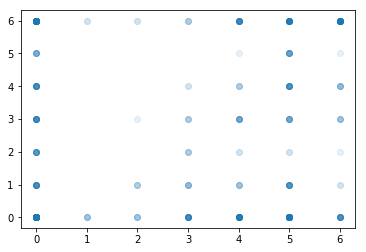

In [54]:
plt.scatter(corr['Field:Medical Needs Score'],corr['Field:LPPN Score'],alpha=0.1)
plt.show()

In [55]:
corr2 = full[['Field:LPPN Score','process_days']].dropna()
pearsonr(corr2['Field:LPPN Score'],corr2['process_days'])

(0.06058520593503715, 0.25288604724284247)

In [56]:
corr2 = full[['Field:Medical Needs Score','process_days']].dropna()
pearsonr(corr2['Field:Medical Needs Score'],corr2['process_days'])

(0.08391809162662373, 0.06262573901534098)

In [57]:
corr2['Field:Medical Needs Score']

3      0.0
5      0.0
7      0.0
13     5.0
16     0.0
      ... 
878    0.0
879    5.0
880    0.0
882    0.0
883    2.0
Name: Field:Medical Needs Score, Length: 493, dtype: float64

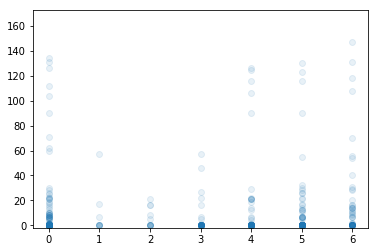

In [58]:
plt.scatter(corr2['Field:Medical Needs Score'],corr2['process_days'],alpha=0.1)
plt.ylim(-2,)
plt.show()

In [59]:
def find_pearson_time(var,df_name):
    df = df_name[[var,'process_days']].dropna()
    p = pearsonr(df[var],df['process_days'])
#     print(var)
#     print("PEARSON: {:.5f} p-value: {:.5f}".format(p[0],p[1]))
    return(p[0])
    

In [60]:
def find_pearson_thresh(var,df_name):
    df = df_name[[var,'Vulnerability Threshold']].dropna()
    p = pearsonr(df[var],df['Vulnerability Threshold'])
#     print(var)
#     print("PEARSON: {:.5f} p-value: {:.5f}".format(p[0],p[1]))
    return(p[0])
    

In [61]:
find_pearson_time('Field:Medical Needs Score',multiple_vars)

-0.0010530542277671355

In [62]:
multiple_vars.columns

Index(['Vulnerability Threshold', 'process_days', 'Field:Age', 'Field:Gender',
       'Field:LPPN Score', 'Field:Medical Condition Assessment',
       'Field:Medical Condition Score', 'Field:Medical Condition 1 Score',
       'Field:Medical Condition 2 Score', 'Field:Medical Condition 3 Score',
       'Field:Medical Needs Score', 'Field:Years in Current Country',
       'nationality_Iraqi', 'nationality_Syrian', 'curr_country_Egypt',
       'curr_country_Iraq', 'curr_country_Lebanon',
       'curr_country_Saudi Arabia', 'curr_country_Syria',
       'curr_country_Turkey'],
      dtype='object')

In [63]:
pearson_time = []
for i in ['Vulnerability Threshold', 'Field:Age', 'Field:Gender',
       'Field:LPPN Score', 'Field:Medical Condition Assessment',
       'Field:Medical Condition Score', 'Field:Medical Condition 1 Score',
       'Field:Medical Condition 2 Score', 'Field:Medical Condition 3 Score',
       'Field:Medical Needs Score', 'Field:Years in Current Country',
       'nationality_Iraqi', 'nationality_Syrian', 'curr_country_Egypt',
       'curr_country_Iraq', 'curr_country_Lebanon',
       'curr_country_Saudi Arabia', 'curr_country_Syria',
       'curr_country_Turkey']:
    pearson_time.append((find_pearson_time(i,multiple_vars),i))
sorted(pearson_time, key=lambda a: abs(a[0]), reverse=True)

/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[(-0.15778867035014985, 'Field:Medical Condition 3 Score'),
 (0.09219787124024523, 'nationality_Iraqi'),
 (-0.0921978712402452, 'nationality_Syrian'),
 (0.07744214274485131, 'Field:Age'),
 (-0.0749151683071375, 'Field:Gender'),
 (-0.07046126861308283, 'Field:Medical Condition 2 Score'),
 (-0.028167119576418737, 'Field:Medical Condition Score'),
 (0.02741890606427947, 'Vulnerability Threshold'),
 (0.027327953800019126, 'curr_country_Iraq'),
 (-0.021002557851902005, 'Field:LPPN Score'),
 (-0.01969411004653231, 'curr_country_Lebanon'),
 (-0.01748533607055804, 'Field:Years in Current Country'),
 (-0.015430236032506307, 'curr_country_Saudi Arabia'),
 (0.011421102674494884, 'curr_country_Egypt'),
 (0.003772743044411331, 'Field:Medical Condition Assessment'),
 (0.0035519399789179867, 'Field:Medical Condition 1 Score'),
 (-0.0010530542277671355, 'Field:Medical Needs Score'),
 (nan, 'curr_country_Syria'),
 (0.013278086727270735, 'curr_country_Turkey')]

In [64]:
pearson_thresh = []
for i in ['process_days', 'Field:Age', 'Field:Gender',
       'Field:LPPN Score', 'Field:Medical Condition Assessment',
       'Field:Medical Condition Score', 'Field:Medical Condition 1 Score',
       'Field:Medical Condition 2 Score', 'Field:Medical Condition 3 Score',
       'Field:Medical Needs Score', 'Field:Years in Current Country',
       'nationality_Iraqi', 'nationality_Syrian', 'curr_country_Egypt',
       'curr_country_Iraq', 'curr_country_Lebanon',
       'curr_country_Saudi Arabia', 'curr_country_Syria',
       'curr_country_Turkey']:
    pearson_thresh.append((find_pearson_thresh(i,multiple_vars),i))
sorted(pearson_thresh, key=lambda a: abs(a[0]), reverse=True)

[(0.15710254706878388, 'Field:Medical Condition 1 Score'),
 (0.14334777471842736, 'Field:Medical Needs Score'),
 (0.1420073515700646, 'Field:Medical Condition Score'),
 (0.1387819717603251, 'Field:LPPN Score'),
 (0.1194376790528901, 'Field:Medical Condition Assessment'),
 (-0.08927314963459561, 'Field:Gender'),
 (0.0707802285856229, 'curr_country_Lebanon'),
 (-0.030429030972509232, 'curr_country_Egypt'),
 (0.02741890606427947, 'process_days'),
 (0.01853446638876584, 'Field:Medical Condition 3 Score'),
 (-0.017352640209845116, 'nationality_Iraqi'),
 (0.017352640209845116, 'nationality_Syrian'),
 (-0.0122467000896329, 'Field:Years in Current Country'),
 (-0.012232930723626231, 'curr_country_Iraq'),
 (-0.012232930723626231, 'curr_country_Saudi Arabia'),
 (0.01119790333008934, 'Field:Age'),
 (0.008618023754328092, 'Field:Medical Condition 2 Score'),
 (nan, 'curr_country_Syria'),
 (-0.05815821362113485, 'curr_country_Turkey')]

#### Regression

In [65]:
x = multiple_vars.drop('Vulnerability Threshold',axis=1)

In [66]:
y = multiple_vars['Vulnerability Threshold']

In [67]:
x2 = multiple_vars.drop('process_days',axis=1)

In [68]:
y2 = multiple_vars['process_days']

In [69]:
logi = LogisticRegression(solver='lbfgs',max_iter=10000)
logi.fit(x,y)
logi2 = LogisticRegression(solver='lbfgs',max_iter=10000)
logi2.fit(x2,y2)

/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Logistic (vulnerability)

In [70]:
sorted(list(zip(logi.coef_[0],x.columns)), key=lambda a: abs(a[0]), reverse=True)

[(-0.5363503737825361, 'Field:Gender'),
 (0.5359658117014381, 'Field:Medical Condition 1 Score'),
 (0.5276203829821431, 'curr_country_Lebanon'),
 (-0.4146989850124395, 'curr_country_Turkey'),
 (0.27874670280447666, 'Field:Medical Needs Score'),
 (0.25747769805352116, 'Field:LPPN Score'),
 (-0.20453888401540254, 'Field:Years in Current Country'),
 (0.1873512835871616, 'Field:Medical Condition Assessment'),
 (-0.1358652913160069, 'Field:Medical Condition 2 Score'),
 (-0.06672571762243087, 'curr_country_Egypt'),
 (-0.045595184956246544, 'curr_country_Saudi Arabia'),
 (0.039733594838322873, 'Field:Age'),
 (0.03714165249818077, 'Field:Medical Condition Score'),
 (-0.02753358929663484, 'nationality_Iraqi'),
 (0.02572399173256545, 'nationality_Syrian'),
 (-0.009202140281589548, 'Field:Medical Condition 3 Score'),
 (-0.0024100929550984773, 'curr_country_Iraq'),
 (0.00039339236503725894, 'process_days'),
 (0.0, 'curr_country_Syria')]

#### Logistic (process days)

In [71]:
sorted(list(zip(logi2.coef_[0],x2.columns)), key=lambda a: abs(a[0]), reverse=True)

[(0.5327488398230077, 'Field:Medical Condition 3 Score'),
 (0.37970456615143827, 'Field:Medical Condition 2 Score'),
 (0.32578540175038306, 'Field:Years in Current Country'),
 (-0.24085278309135108, 'Field:Age'),
 (0.23063111971256137, 'Field:LPPN Score'),
 (0.17791562872115313, 'Field:Medical Condition Score'),
 (0.12744832809971368, 'Field:Medical Condition 1 Score'),
 (0.09965287989752812, 'Field:Medical Needs Score'),
 (0.0827375389814776, 'Field:Medical Condition Assessment'),
 (-0.02255628699188481, 'nationality_Syrian'),
 (0.019895298560966078, 'Field:Gender'),
 (-0.014898038061742508, 'curr_country_Turkey'),
 (-0.005767702291251902, 'curr_country_Egypt'),
 (-0.003906331143286851, 'Vulnerability Threshold'),
 (-0.0021393599624748502, 'curr_country_Lebanon'),
 (-0.0009283004055303639, 'nationality_Iraqi'),
 (-0.0004008377975674102, 'curr_country_Saudi Arabia'),
 (-0.00027864928437145196, 'curr_country_Iraq'),
 (0.0, 'curr_country_Syria')]

#### Random Forest  (vulnerability)

In [72]:
rf = RandomForestClassifier()
rf.fit(x,y)
sorted(list(zip(rf.feature_importances_,x.columns)),reverse=True)

[(0.25947164503595727, 'process_days'),
 (0.15413805801364372, 'Field:Age'),
 (0.1361423229140168, 'Field:Years in Current Country'),
 (0.07598585714430789, 'Field:LPPN Score'),
 (0.0703194619569517, 'Field:Medical Condition Score'),
 (0.0643425884024398, 'Field:Medical Condition 2 Score'),
 (0.05521513844819893, 'Field:Medical Condition Assessment'),
 (0.05003436774190384, 'Field:Medical Condition 1 Score'),
 (0.045438104541449656, 'Field:Gender'),
 (0.03856344854312845, 'Field:Medical Needs Score'),
 (0.03235337139388772, 'Field:Medical Condition 3 Score'),
 (0.006693556476426362, 'curr_country_Lebanon'),
 (0.006138081285350807, 'curr_country_Turkey'),
 (0.004162782760082236, 'curr_country_Egypt'),
 (0.0009888934163527223, 'nationality_Syrian'),
 (1.2321925902172786e-05, 'curr_country_Saudi Arabia'),
 (0.0, 'nationality_Iraqi'),
 (0.0, 'curr_country_Syria'),
 (0.0, 'curr_country_Iraq')]

#### Random Forest  (process days)

In [73]:
rf = RandomForestClassifier()
rf.fit(x2,y2)
sorted(list(zip(rf.feature_importances_,x.columns)),reverse=True)

[(0.1988496093595951, 'Field:Age'),
 (0.14147439722220978, 'Field:Years in Current Country'),
 (0.12183734301177507, 'Field:LPPN Score'),
 (0.08644917199423974, 'Field:Medical Condition 1 Score'),
 (0.06663065375112835, 'Field:Medical Condition 2 Score'),
 (0.06641584997466593, 'Field:Medical Needs Score'),
 (0.05948720694940147, 'Field:Medical Condition Assessment'),
 (0.05869856412226503, 'Field:Medical Condition Score'),
 (0.04807885205176562, 'Field:Medical Condition 3 Score'),
 (0.043794296709301746, 'Field:Gender'),
 (0.029512426715233273, 'process_days'),
 (0.01776036898401047, 'curr_country_Lebanon'),
 (0.017071813285520016, 'curr_country_Turkey'),
 (0.01156781426349445, 'nationality_Syrian'),
 (0.01046149555304751, 'curr_country_Iraq'),
 (0.010162059310328828, 'nationality_Iraqi'),
 (0.006132356610932722, 'curr_country_Saudi Arabia'),
 (0.005615720131084914, 'curr_country_Egypt'),
 (0.0, 'curr_country_Syria')]